In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# layers
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
# model
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import SGD, Adam

# additional imports
import numpy as np # linear algebra
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # data visualisation

In [0]:
# Generate synthetic data
# Because we squared the data
# The frequency and hence also the period of the time wave changes over time
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:

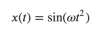

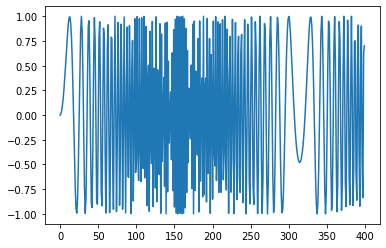

In [0]:
# Plot the data
plt.plot(series)
plt.show()

In [0]:
### Build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # Make it NxT
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (390, 10) Y.shape (390,)


In [0]:
### try autoregressive linear model
i = Input(shape = (T,))
x = Dense(1)(i)
model = Model(i,x)
model.compile(loss = 'mse', optimizer = Adam(lr = 0.01))


# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    validation_data = (X[-N//2:], Y[-N//2:]),
    epochs = 80
)

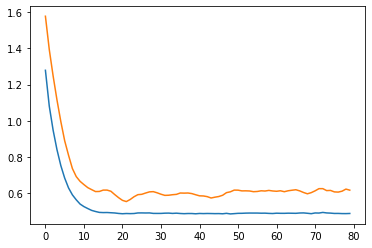

In [0]:
# plot the loss
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.show()

(390, 1)


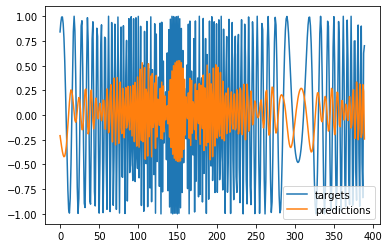

In [0]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label = 'targets')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()

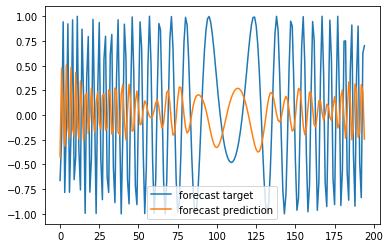

In [0]:
# This is the code we had before - it does the same thing
# One-step forecast using true targets 

validation_target = Y[-N//2:]
validation_predictions = []

# index of the first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1,-1))[0,0] #1x1 array -> scalar
  i += 1

  # update the prediction list
  validation_predictions.append(p)

plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediction')
plt.legend()
plt.show()

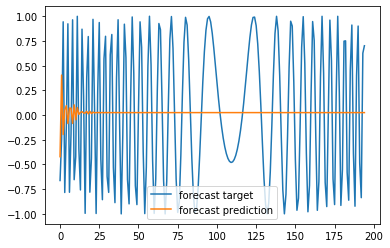

In [0]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_preds = []

# last train input
last_x = X[-N//2] #1-D array of length T

while len(validation_preds) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_preds.append(p)

  # make the new input
  last_x = np.roll(last_x, -1) # shift everything to the left
  last_x[-1] = p

plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_preds, label = 'forecast prediction')
plt.legend()
plt.show()

In [0]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape = (T, D))
x = GRU(10)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(loss = 'mse', optimizer = Adam(lr = 0.05))

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    batch_size = 32,
    epochs = 200,
    validation_data = (X[-N//2:], Y[-N//2:])
)

(390, 1)


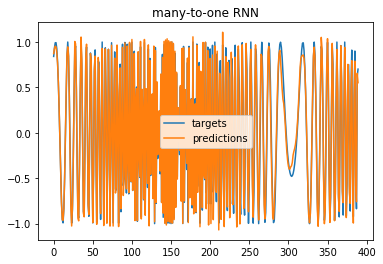

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
preds = outputs[:,0]

plt.plot(Y, label = 'targets')
plt.plot(preds, label = 'predictions')
plt.title('many-to-one RNN')
plt.legend()
plt.show()

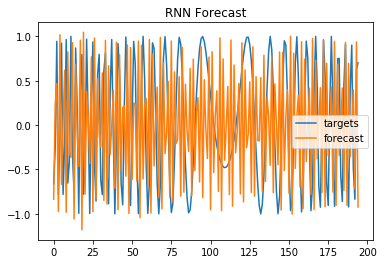

In [0]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # reshape the input to NxTxD
  f = model.predict(input_.reshape(-1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f
plt.plot(Y[-N//2:], label = 'targets')
plt.plot(forecast, label = 'forecast')
plt.title('RNN Forecast')
plt.legend()
plt.show()